In [24]:
from pathlib import Path
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', 0)

import pickle
import sys
import os
import json

if ".." not in sys.path:
    sys.path.append("..")
    
from typing import Dict, Tuple, Sequence, List

import matplotlib.pyplot as plt

In [25]:
from pp5 import OUT_DIR

PVAL_THRESH = 1.0

PREC_OUT_DIR = OUT_DIR.joinpath("prec-collected")
RESULTS_TAG = "pointwise_cdist-t_2-n_1-k_1000-noss"
# RESULTS_TAG = "pointwise_cdist-tmp"
INTERMEDIATE_DIR = "_intermediate_"

DATASET_DIRS = (
    PREC_OUT_DIR.joinpath("20210707_134426-aida-ex_EC-src_EC"),
#     PREC_OUT_DIR.joinpath("20210102_112030-aida-ex_EC-src_HS-r18"),
#     PREC_OUT_DIR.joinpath("20210102_112750-aida-ex_EC-src_ALL-r18"),
#     PREC_OUT_DIR.joinpath("20210505_131701-photon"),
)


### Dataset stats

In [26]:
from pp5.analysis import DSSP_TO_SS_TYPE

# Maps from dataset tag to a metadata dict
datasets_meta = {}

# Maps from dataset tag to the group_sizes dict from results meta.json
datasets_group_sizes: Dict[str, dict] = {}

# Maps from dataset tag to it's path
dataset_result_dirs: Dict[str, Path] = {}

for i, ds_dir in enumerate(DATASET_DIRS):
    # Load dataset metadata
    meta_path = ds_dir.joinpath("meta.json")
    with open(meta_path, "r") as f:
        ds_meta = json.load(f)
    for _col in ("steps","async_timeout","create_zip"):
        ds_meta.pop(_col)
    tag = ds_meta.pop("out_tag") or f"ds_{i:02d}"
    
    
    # Load results metadata
    results_meta_path = ds_dir.joinpath("results", RESULTS_TAG, "meta.json")
    with open(results_meta_path, "r") as f:
        results_meta = json.load(f)

    # Copy some stats over from the results meta
    for group, group_meta in results_meta["group_sizes"].items():
        ds_meta[f"n_{group}"] = group_meta["total"]
    for _col in ("codon_tuple_len", "min_group_size", "t2_n_max", "t2_permutations"):
        ds_meta[_col] = results_meta[_col]
        
    # Save all group sizes
    datasets_group_sizes[tag] = results_meta["group_sizes"]
        
    # Load data
    data_prec_path = ds_dir.joinpath("data-precs.csv")
    df_pointwise = pd.read_csv(
        data_prec_path,
        usecols=("pdb_id", "res_id", "unp_id", "unp_idx", "codon", "secondary"),
        dtype={"unp_idx": "Int64"},
        header=0,
        # Consolidate different SS types into the ones we support
        converters={"secondary": lambda ss: DSSP_TO_SS_TYPE.get(ss, "")},
    )
    
    # Save some stats
    ds_meta["n_PDB_structs"] = len(df_pointwise.pdb_id.unique())
    ds_meta["n_UNP_records"] = len(df_pointwise.unp_id.unique())
    
    dataset_result_dirs[tag] = ds_dir.joinpath("results", RESULTS_TAG, INTERMEDIATE_DIR)
    assert dataset_result_dirs[tag].is_dir()
    datasets_meta[tag] = ds_meta
    
    ############
    # break


/Users/aviv/miniconda3/envs/proteins/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [27]:
df_datasets_meta = pd.DataFrame(datasets_meta)
df_datasets_meta.to_csv(f"out/pointwise_dataset_stats.csv", float_format="%.3f")
df_datasets_meta

,ex_EC-src_EC
codon_tuple_len,2
dataset_size_mb,29.90
expr_sys,Escherichia Coli
hostname,aida
id,20210707_134426-aida-ex_EC-src_EC
min_group_size,1
n_ANY,93694
n_PDB_structs,1621
n_UNP_records,581
n_collected,1980


In [28]:
len(df_pointwise.pdb_id.unique()),  len(df_pointwise.unp_id.unique())

(1621, 581)

## Helper Functions

In [29]:
def load_results(
    dataset_result_dirs: Dict[str, Path], result_names: Sequence[str]
) -> Dict[str, Sequence[Dict]]:
    
    # maps dataset tag -> [results_dict1, results_dict2, ...]
    dataset_loaded_results: Dict[str, Sequence[Dict]] = {}

    for ds_tag, ds_dir in dataset_result_dirs.items():

        loaded_results = []

        for result_name in result_names:

            result_path = ds_dir.joinpath(result_name)
            assert result_path.is_file(), f"{ds_tag=} {result_name=}"

            with open(result_path, 'rb') as f:
                p = pickle.load(f)
                # remove the length-1 array
                # p = {k: v[0] for k,v in p.items()}

            loaded_results.append(p)

        dataset_loaded_results[ds_tag] = loaded_results
    
    return dataset_loaded_results

In [30]:
import itertools as it

csv_float_fmt = "%.5f"

def results_to_df(
    results: Dict[Tuple, Dict],
    index_col_names: Sequence[str],
    sort_by: Sequence[str] = (),
    split_cols: Sequence[str] = (),
    split_cols_delim: str = "_",
    write_csv: str=None,
):
    
    index = [k for k, v in results.items() for _ in v]
    index = pd.MultiIndex.from_tuples(index, names=index_col_names)
    
    data = it.chain(*results.values())
    df = pd.DataFrame(data=data, index=index)
    
    # Sort: always sort by index colums, and then by additional sort columns
    df = df.sort_values(by=[*index_col_names, *sort_by])
    
    # Split columns based on delimiter
    for col in split_cols:
        split_cols = df[col].str.split(split_cols_delim, -1, expand=True)
        split_cols.columns = [f"{col}.{i+1}" for i in split_cols.columns]
        df = pd.concat([df, split_cols], axis=1)
    
    if write_csv:
        df.to_csv(write_csv, float_format=csv_float_fmt)

    return df
    

### Codon vs. Codon

In [31]:
CODON_DIHEDRAL_PVALS = "codon-dihedral-pvals.pkl"
CODON_DIHEDRAL_T2S = "codon-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_codon_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs,
    result_names=[CODON_DIHEDRAL_PVALS, CODON_DIHEDRAL_T2S]
)

In [32]:
from pp5.codons import aac_tuples, aac_tuple_pairs, aac_index_pairs, AAC_TUPLE_SEP

# Assuming all results have the same tuple length
tuple_len = ds_meta["codon_tuple_len"]


SYN_TUPLES_IDX = sorted(aac_index_pairs(k=tuple_len, synonymous=True, unique=True))
SYN_TUPLES_IDX = np.array(SYN_TUPLES_IDX)

AAC_TUPLES = [str.join(AAC_TUPLE_SEP, (a1, a2)) for (a1, a2) in aac_tuples(k=2)]

print(f'{len(SYN_TUPLES_IDX)=}, {len(AAC_TUPLES)=}')

len(SYN_TUPLES_IDX)=29473, len(AAC_TUPLES)=3721


In [10]:

results_cc = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_codon_dists.items():
    
    assert ds_pvals.keys() == ds_t2s.keys()
    
    for ss_type in ds_pvals.keys():
        
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2 = ds_t2s[ss_type]
        
        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]['subgroups']
        
        syn_codon_pvals = ds_ss_pvals[tuple(zip(*SYN_TUPLES_IDX))]
        syn_significant_idx_flat = syn_codon_pvals <= PVAL_THRESH
        syn_significant_idx = SYN_TUPLES_IDX[syn_significant_idx_flat]
        
        results_cc[(ds_tag,ss_type)] = [
            {
                "tuple1": AAC_TUPLES[aac1],
                "tuple2": AAC_TUPLES[aac2],
                "n1": ds_ss_subgroup_sizes[AAC_TUPLES[aac1]],
                "n2": ds_ss_subgroup_sizes[AAC_TUPLES[aac2]],
                "pval": ds_ss_pvals[aac1, aac2],
                "t2": ds_ss_t2[aac1, aac2],
            }
            for aac1, aac2 in syn_significant_idx
        ]

In [11]:
index_col_names = ["Dataset", "SS"]

df_pvals_cc = results_to_df(
    results_cc,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_cc-{PVAL_THRESH}.csv",
    split_cols=['tuple1', 'tuple2'],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_cc

tuple1       tuple2   n1   n2  pval         t2  \
Dataset      SS                                                         
ex_EC-src_EC ANY  A-GCA_S-TCC  A-GCC_S-AGC  14   115  0.0   27.027071   
             ANY  A-GCC_R-CGC  A-GCG_R-AGA  65   16   0.0   5.733239    
             ANY  A-GCC_R-CGT  A-GCG_R-AGA  56   16   0.0   8.411426    
             ANY  A-GCC_S-TCA  A-GCC_S-TCG  11   11   0.0   10.718183   
             ANY  A-GCG_R-AGA  A-GCG_R-CGA  16   24   0.0   5.608682    
             ANY  A-GCG_R-AGA  A-GCG_R-CGC  16   70   0.0   10.345638   
             ANY  A-GCG_R-AGA  A-GCG_R-CGT  16   90   0.0   13.696796   
             ANY  A-GCG_R-AGA  A-GCT_R-CGC  16   41   0.0   15.622354   
             ANY  A-GCG_R-AGA  A-GCT_R-CGT  16   28   0.0   6.979459    
             ANY  E-GAA_H-CAC  E-GAG_H-CAC  34   32   0.0   14.106009   
             ANY  F-TTC_P-CCC  F-TTT_P-CCA  8    15   0.0   13.969500   
             ANY  F-TTC_P-CCG  F-TTT_P-CCA  29   15   0.0   16.499479   
             ANY  G-GGA_G-GGA  G-GGG_G-GGT  5    7    0.0   9.109258    
             ANY  G-GGA_G-GGC  G-GGT_G-GGC  18   59   0.0   8.019620    
             ANY  G-GGA_L-CTG  G-GGC_L-TTG  29   16   0.0   9.534359    
             ANY  G-GGC_E-GAA  G-GGT_E-GAA  106  90   0.0   11.136639   
             ANY  G-GGC_L-CTG  G-GGC_L-TTG  89   16   0.0   23.331438   
             ANY  G-GGC_S-AGC  G-GGC_S-AGT  42   35   0.0   9.750817    
             ANY  G-GGC_T-ACA  G-GGC_T-ACC  18   66   0.0   15.450260   
             ANY  H-CAC_R-CGA  H-CAT_R-AGA  4    2    0.0   9.458727    
             ANY  I-ATC_A-GCC  I-ATT_A-GCG  125  75   0.0   15.999228   
             ANY  I-ATC_R-AGA  I-ATT_R-CGG  8    14   0.0   12.522663   
...                       ...          ...  ...  ..   ...         ...   
             ANY  S-AGC_P-CCT  S-AGT_P-CCT  2    2    1.0   0.268739    
             ANY  S-AGC_P-CCT  S-TCC_P-CCG  2    2    1.0   0.704250    
             ANY  S-AGC_R-AGA  S-TCG_R-AGA  2    2    1.0   0.399151    
             ANY  S-AGC_R-CGA  S-TCG_R-AGA  6    2    1.0   0.194209    
             ANY  S-AGC_S-TCC  S-TCA_S-AGT  5    3    1.0  -0.204907    
             ANY  S-AGC_T-ACA  S-AGT_T-ACT  2    2    1.0   0.718867    
             ANY  S-AGC_V-GTG  S-TCG_V-GTA  26   14   1.0  -0.661604    
             ANY  S-AGT_P-CCA  S-AGT_P-CCC  2    3    1.0   0.335779    
             ANY  S-AGT_P-CCA  S-AGT_P-CCT  2    2    1.0   0.063922    
             ANY  S-AGT_P-CCA  S-TCG_P-CCT  2    3    1.0   0.355830    
             ANY  S-AGT_P-CCC  S-AGT_P-CCT  3    2    1.0   0.451336    
             ANY  S-AGT_P-CCC  S-TCC_P-CCT  3    2    1.0   0.073067    
             ANY  S-AGT_P-CCG  S-TCC_P-CCG  2    2    1.0  -0.185544    
             ANY  S-AGT_P-CCT  S-TCG_P-CCT  2    3    1.0   0.485675    
             ANY  S-AGT_V-GTC  S-TCG_V-GTA  4    14   1.0  -0.553729    
             ANY  S-TCC_P-CCG  S-TCC_P-CCT  2    2    1.0  -0.017953    
             ANY  S-TCC_P-CCG  S-TCT_P-CCA  2    2    1.0   0.968879    
             ANY  S-TCT_R-CGC  S-TCT_R-CGT  21   7    1.0  -0.104867    
             ANY  T-ACA_R-AGA  T-ACT_R-CGA  2    2    1.0   0.456679    
             ANY  T-ACG_T-ACC  T-ACG_T-ACG  27   15   1.0  -0.640692    
             ANY  T-ACT_P-CCA  T-ACT_P-CCC  3    4    1.0   0.247317    
             ANY  V-GTA_T-ACC  V-GTG_T-ACC  22   67   1.0  -0.469984    

                 tuple1.1 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                                       
ex_EC-src_EC ANY  A-GCA    S-TCC    A-GCC    S-AGC    
             ANY  A-GCC    R-CGC    A-GCG    R-AGA    
             ANY  A-GCC    R-CGT    A-GCG    R-AGA    
             ANY  A-GCC    S-TCA    A-GCC    S-TCG    
             ANY  A-GCG    R-AGA    A-GCG    R-CGA    
             ANY  A-GCG    R-AGA    A-GCG    R-CGC    
             ANY  A-GCG    R-AGA    A-GCG    R-CGT    
             ANY  A-GCG    R-AGA    A-GCT    R-CGC    
             ANY  A-GCG    R-AGA    A-GCT

### AA vs. AA

In [12]:
AA_DIHEDRAL_PVALS = "aa-dihedral-pvals.pkl"
AA_DIHEDRAL_T2S = "aa-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_aa_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs,
    result_names=[AA_DIHEDRAL_PVALS, AA_DIHEDRAL_T2S]
)

In [13]:
from pp5.codons import aac_tuples, aac_tuple_pairs, aac_index_pairs, AAC_TUPLE_SEP


AA_TUPLES = [str.join(AAC_TUPLE_SEP, (a1[0], a2[0])) for (a1, a2) in aac_tuples(k=2)]
AA_TUPLES = sorted(set(AA_TUPLES))
print(f"{len(AA_TUPLES)=}")

len(AA_TUPLES)=400


In [14]:
results_aa = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_aa_dists.items():
    
    assert ds_pvals.keys() == ds_t2s.keys()
    
    for ss_type in ds_pvals.keys():
        
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2 = ds_t2s[ss_type]
        
        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]['subgroups']
        
        # Temp hack: remove redundant entries because for some reason they were calcualted
        ds_ss_pvals[np.tril_indices_from(ds_ss_pvals, k=-1)]=np.nan
        
        # [(aa1, aa2), (aa3, aa4), ...]
        aa_significant_idx = list(zip(
            # where returns ((aa1, aa2, ...), (codon1, codon2, ...))
            *np.where(ds_ss_pvals <= PVAL_THRESH)
        ))
        
        results_aa[(ds_tag,ss_type)] = [
            {
                "tuple1": AA_TUPLES[aa1],
                "tuple2": AA_TUPLES[aa2],
                "n1": ds_ss_subgroup_sizes[AA_TUPLES[aa1]],
                "n2": ds_ss_subgroup_sizes[AA_TUPLES[aa2]],
                "pval": ds_ss_pvals[aa1, aa2],
                "t2": ds_ss_t2[aa1, aa2]
            }
            for aa1, aa2 in aa_significant_idx
        ]
        
        print(f"{ss_type}: {len(aa_significant_idx)=}")

ANY: len(aa_significant_idx)=79800


In [15]:

df_pvals_aa = results_to_df(
    results_aa,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_aa-{PVAL_THRESH}.csv",
    split_cols=['tuple1', 'tuple2'],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_aa

tuple1 tuple2    n1    n2  pval          t2 tuple1.1  \
Dataset      SS                                                         
ex_EC-src_EC ANY  A_A    A_F    1197  391   0.0   56.717167   A         
             ANY  A_A    A_G    1197  760   0.0   500.013977  A         
             ANY  A_A    A_H    1197  194   0.0   23.095268   A         
             ANY  A_A    A_I    1197  614   0.0   94.488945   A         
             ANY  A_A    A_L    1197  1175  0.0   16.751602   A         
             ANY  A_A    A_N    1197  372   0.0   21.196394   A         
             ANY  A_A    A_P    1197  178   0.0   123.700546  A         
             ANY  A_A    A_S    1197  519   0.0   49.342335   A         
             ANY  A_A    A_T    1197  445   0.0   89.997337   A         
             ANY  A_A    A_V    1197  776   0.0   194.535248  A         
             ANY  A_A    A_W    1197  170   0.0   25.090811   A         
             ANY  A_A    A_Y    1197  232   0.0   36.175545   A         
             ANY  A_A    C_A    1197  88    0.0   23.103479   A         
             ANY  A_A    C_G    1197  75    0.0   51.200752   A         
             ANY  A_A    C_I    1197  62    0.0   72.278061   A         
             ANY  A_A    D_F    1197  247   0.0   29.655663   A         
             ANY  A_A    D_G    1197  486   0.0   588.306152  A         
             ANY  A_A    D_I    1197  359   0.0   68.390320   A         
             ANY  A_A    D_K    1197  308   0.0   18.270838   A         
             ANY  A_A    D_L    1197  440   0.0   38.768749   A         
             ANY  A_A    D_N    1197  243   0.0   31.345428   A         
             ANY  A_A    D_P    1197  70    0.0   396.821136  A         
...               ...    ...     ...  ...   ...         ...  ..         
             ANY  V_N    Y_R    293   206   1.0  -0.766477    V         
             ANY  V_P    Y_P    147   81    1.0  -1.256036    V         
             ANY  V_Q    W_D    282   80    1.0  -1.000792    V         
             ANY  V_Q    W_E    282   84    1.0  -1.137505    V         
             ANY  V_Q    W_H    282   40    1.0  -0.519683    V         
             ANY  V_Q    W_R    282   99    1.0  -0.638940    V         
             ANY  V_Q    W_S    282   69    1.0  -1.124332    V         
             ANY  V_Q    Y_K    282   100   1.0  -0.320388    V         
             ANY  V_Q    Y_Q    282   160   1.0  -0.810685    V         
             ANY  V_Q    Y_S    282   163   1.0  -2.698909    V         
             ANY  V_Q    Y_Y    282   107   1.0  -0.811862    V         
             ANY  V_R    W_E    399   84    1.0  -0.663735    V         
             ANY  V_R    W_S    399   69    1.0  -0.542825    V         
             ANY  V_R    Y_S    399   163   1.0  -1.886246    V         
             ANY  V_R    Y_Y    399   107   1.0  -0.586757    V         
             ANY  V_T    W_T    476   78    1.0  -0.742099    V         
             ANY  V_W    W_T    108   78    1.0  -0.426001    V         
             ANY  V_W    Y_C    108   31    1.0  -0.633995    V         
             ANY  V_Y    W_T    206   78    1.0  -1.069316    V         
             ANY  W_I    Y_S    65    163   1.0  -0.616917    W         
             ANY  Y_C    Y_F    31    135   1.0  -0.709924    Y         
             ANY  Y_C    Y_I    31    150   1.0  -0.446404    Y         

                 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                              
ex_EC-src_EC ANY  A        A        F        
             ANY  A        A        G        
             ANY  A        A        H        
             ANY  A        A        I        
             ANY  A        A        L        
             ANY  A        A        N        
             ANY  A        A        P        
             ANY  A        A        S        
             ANY  A        A        T        
             ANY  A        A        V        
             ANY  A        A     

In [16]:
# Filter out G & P
filter_pattern = "[^GP]_[^GP]"
idx = pd.Series([True]*len(df_pvals_aa),index=df_pvals_aa.index)
print(sum(idx))
for col in ('tuple1', 'tuple2'):
    idx &= df_pvals_aa[col].str.fullmatch(filter_pattern)
    print(sum(idx))
    
df_pvals_aa_filtered = df_pvals_aa[idx]
df_pvals_aa_filtered = df_pvals_aa_filtered.sort_values(by=[*index_col_names,"pval"])
df_pvals_aa_filtered.to_csv(f"out/pointwise_pvals_aa-{PVAL_THRESH}-filtered.csv", float_format=csv_float_fmt)
df_pvals_aa_filtered

79800
63882
52326


tuple1 tuple2    n1    n2  pval          t2 tuple1.1  \
Dataset      SS                                                         
ex_EC-src_EC ANY  A_A    A_F    1197  391   0.0   56.717167   A         
             ANY  A_A    A_H    1197  194   0.0   23.095268   A         
             ANY  A_A    A_I    1197  614   0.0   94.488945   A         
             ANY  A_A    A_L    1197  1175  0.0   16.751602   A         
             ANY  A_A    A_N    1197  372   0.0   21.196394   A         
             ANY  A_A    A_S    1197  519   0.0   49.342335   A         
             ANY  A_A    A_T    1197  445   0.0   89.997337   A         
             ANY  A_A    A_V    1197  776   0.0   194.535248  A         
             ANY  A_A    A_W    1197  170   0.0   25.090811   A         
             ANY  A_A    A_Y    1197  232   0.0   36.175545   A         
             ANY  A_A    C_A    1197  88    0.0   23.103479   A         
             ANY  A_A    C_I    1197  62    0.0   72.278061   A         
             ANY  A_A    D_F    1197  247   0.0   29.655663   A         
             ANY  A_A    D_I    1197  359   0.0   68.390320   A         
             ANY  A_A    D_K    1197  308   0.0   18.270838   A         
             ANY  A_A    D_L    1197  440   0.0   38.768749   A         
             ANY  A_A    D_N    1197  243   0.0   31.345428   A         
             ANY  A_A    D_T    1197  249   0.0   48.460716   A         
             ANY  A_A    D_V    1197  389   0.0   95.312958   A         
             ANY  A_A    D_Y    1197  196   0.0   38.712967   A         
             ANY  A_A    E_F    1197  232   0.0   44.095520   A         
             ANY  A_A    E_H    1197  144   0.0   14.510076   A         
...               ...    ...     ...  ...   ...         ...  ..         
             ANY  V_M    Y_T    193   151   1.0  -0.813188    V         
             ANY  V_N    Y_R    293   206   1.0  -0.766477    V         
             ANY  V_Q    W_D    282   80    1.0  -1.000792    V         
             ANY  V_Q    W_E    282   84    1.0  -1.137505    V         
             ANY  V_Q    W_H    282   40    1.0  -0.519683    V         
             ANY  V_Q    W_R    282   99    1.0  -0.638940    V         
             ANY  V_Q    W_S    282   69    1.0  -1.124332    V         
             ANY  V_Q    Y_K    282   100   1.0  -0.320388    V         
             ANY  V_Q    Y_Q    282   160   1.0  -0.810685    V         
             ANY  V_Q    Y_S    282   163   1.0  -2.698909    V         
             ANY  V_Q    Y_Y    282   107   1.0  -0.811862    V         
             ANY  V_R    W_E    399   84    1.0  -0.663735    V         
             ANY  V_R    W_S    399   69    1.0  -0.542825    V         
             ANY  V_R    Y_S    399   163   1.0  -1.886246    V         
             ANY  V_R    Y_Y    399   107   1.0  -0.586757    V         
             ANY  V_T    W_T    476   78    1.0  -0.742099    V         
             ANY  V_W    W_T    108   78    1.0  -0.426001    V         
             ANY  V_W    Y_C    108   31    1.0  -0.633995    V         
             ANY  V_Y    W_T    206   78    1.0  -1.069316    V         
             ANY  W_I    Y_S    65    163   1.0  -0.616917    W         
             ANY  Y_C    Y_F    31    135   1.0  -0.709924    Y         
             ANY  Y_C    Y_I    31    150   1.0  -0.446404    Y         

                 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                              
ex_EC-src_EC ANY  A        A        F        
             ANY  A        A        H        
             ANY  A        A        I        
             ANY  A        A        L        
             ANY  A        A        N        
             ANY  A        A        S        
             ANY  A        A        T        
             ANY  A        A        V        
             ANY  A        A        W        
             ANY  A        A        Y        
             ANY  A        C     

### AA vs. Codon

In [17]:
AAC_DIHEDRAL_PVALS = "aac-dihedral-pvals.pkl"
AAC_DIHEDRAL_T2S = "aac-dihedral-t2s.pkl"

# maps dataset tag -> (pval results, t2 results)
dataset_aac_dists: Dict[str, Sequence[Dict]] = load_results(
    dataset_result_dirs,
    result_names=[AAC_DIHEDRAL_PVALS, AAC_DIHEDRAL_T2S]
)

In [18]:

def is_aat_aact_match(aat: str, aact: str):
    for aa, aac in zip(aat.split(AAC_TUPLE_SEP), aact.split(AAC_TUPLE_SEP)):
        if aa != aac[0]:
            return False
    return True

AA_AAC_TUPLES = sorted(set(
    (aa, codon)
    for aa in AA_TUPLES
    for codon in AAC_TUPLES
    if is_aat_aact_match(aa, codon)
))

print(f"{len(AA_AAC_TUPLES)}")

3721


In [19]:

results_ac = {}

for ds_tag, (ds_pvals, ds_t2s) in dataset_aac_dists.items():
    assert ds_pvals.keys() == ds_t2s.keys()
    for ss_type in ds_pvals.keys():
        ds_ss_pvals = ds_pvals[ss_type]
        ds_ss_t2s = ds_t2s[ss_type]
        ds_ss_subgroup_sizes = datasets_group_sizes[ds_tag][ss_type]['subgroups']
    
        # [(aa1, codon1), (aa2, codon2), ...]
        aac_significant_idx = list(zip(
            # where returns ((aa1, aa2, ...), (codon1, codon2, ...))
            *np.where(ds_ss_pvals <= PVAL_THRESH)
        ))
        
        results_ac[(ds_tag, ss_type)] = [
            {
                "tuple1": AA_TUPLES[aa],
                "tuple2": AAC_TUPLES[codon],
                "n1": ds_ss_subgroup_sizes[AA_TUPLES[aa]],
                "n2": ds_ss_subgroup_sizes[AAC_TUPLES[codon]],
                "pval": ds_ss_pvals[aa, codon],
                "t2": ds_ss_t2s[aa, codon],
            }
            for aa, codon in aac_significant_idx
        ]

In [20]:
df_pvals_ac = results_to_df(
    results_ac,
    index_col_names=index_col_names,
    sort_by=["pval"],
    write_csv=f"out/pointwise_pvals_ac-{PVAL_THRESH}.csv",
    split_cols=['tuple1', 'tuple2'],
    split_cols_delim=AAC_TUPLE_SEP,
)

df_pvals_ac

tuple1       tuple2    n1  n2   pval          t2 tuple1.1  \
Dataset      SS                                                              
ex_EC-src_EC ANY  A_R    A-GCG_R-AGA  574   16  0.000  93.034698   A         
             ANY  F_P    F-TTT_P-CCA  79    15  0.000  34.545200   F         
             ANY  I_A    I-ATT_A-GCG  705   75  0.000  10.958311   I         
             ANY  I_R    I-ATT_R-CGG  317   14  0.000  142.511322  I         
             ANY  K_R    K-AAG_R-CGG  227   6   0.000  58.376617   K         
             ANY  L_T    L-CTT_T-ACG  528   13  0.000  182.069458  L         
             ANY  N_V    N-AAC_V-GTG  282   44  0.000  12.834173   N         
             ANY  P_G    P-CCC_G-GGC  362   47  0.000  13.154759   P         
             ANY  P_R    P-CCG_R-CGG  130   15  0.000  30.545673   P         
             ANY  R_G    R-CGG_G-GGA  336   6   0.000  30.914198   R         
             ANY  R_I    R-AGA_I-ATC  307   11  0.000  246.007065  R         
             ANY  E_H    E-GAG_H-CAC  144   32  0.001  11.501815   E         
             ANY  G_L    G-GGC_L-TTG  511   16  0.001  35.815495   G         
             ANY  T_M    T-ACA_M-ATG  108   18  0.001  10.308590   T         
             ANY  V_T    V-GTG_T-ACG  476   81  0.001  15.283545   V         
             ANY  T_E    T-ACT_E-GAG  263   15  0.002  28.131630   T         
             ANY  G_T    G-GGC_T-ACC  312   66  0.003  7.414258    G         
             ANY  H_T    H-CAT_T-ACG  124   18  0.003  10.336154   H         
             ANY  V_A    V-GTC_A-GCA  750   16  0.003  10.580762   V         
             ANY  G_G    G-GGA_G-GGC  432   18  0.004  7.425900    G         
             ANY  L_I    L-CTC_I-ATC  580   30  0.004  9.189999    L         
             ANY  G_R    G-GGG_R-CGG  294   16  0.005  7.537355    G         
...               ...            ...  ...   ..    ...       ...   ..         
             ANY  T_L    T-ACT_L-CTG  655   38  0.993 -0.247420    T         
             ANY  L_R    L-CTT_R-CGT  562   10  0.994 -0.104778    L         
             ANY  P_Q    P-CCT_Q-CAA  209   8   0.994 -0.320134    P         
             ANY  S_T    S-AGT_T-ACG  214   4   0.994 -0.194670    S         
             ANY  C_T    C-TGC_T-ACC  41    9   0.996 -0.355563    C         
             ANY  N_R    N-AAT_R-CGT  193   16  0.996 -0.461483    N         
             ANY  G_W    G-GGA_W-TGG  94    12  0.997 -0.475987    G         
             ANY  L_S    L-CTG_S-TCT  479   18  0.997 -0.386532    L         
             ANY  R_F    R-CGG_F-TTC  242   2   0.997 -0.118552    R         
             ANY  T_E    T-ACA_E-GAG  263   16  0.997 -0.361810    T         
             ANY  V_T    V-GTA_T-ACC  476   22  0.997 -0.342396    V         
             ANY  H_R    H-CAC_R-AGA  104   2   0.998 -0.181380    H         
             ANY  A_R    A-GCT_R-CGA  574   4   0.999 -0.074137    A         
             ANY  E_T    E-GAG_T-ACA  328   7   0.999 -0.519922    E         
             ANY  G_D    G-GGA_D-GAT  299   2   0.999 -0.224835    G         
             ANY  L_N    L-TTA_N-AAC  470   14  0.999 -0.229314    L         
             ANY  R_T    R-AGA_T-ACG  201   8   0.999 -0.432251    R         
             ANY  A_L    A-GCC_L-CTT  1175  18  1.000 -0.475991    A         
             ANY  A_N    A-GCC_N-AAC  372   66  1.000 -0.422817    A         
             ANY  G_R    G-GGA_R-CGG  294   7   1.000 -0.802722    G         
             ANY  G_R    G-GGC_R-CGA  294   5   1.000 -0.566785    G         
             ANY  L_R    L-TTG_R-CGT  562   55  1.000 -0.489257    L         

                 tuple1.2 tuple2.1 tuple2.2  
Dataset      SS                              
ex_EC-src_EC ANY  R        A-GCG    R-AGA    
             ANY  P        F-TTT    P-CCA    
             ANY  A        I-ATT    A-GCG    
             ANY  R        I-ATT    R-CGG    
             ANY  R        K-AAG    R-CGG    
             ANY  T        L

## Figures

In [21]:
def mht_bh(q: float, pvals: np.ndarray, plot=False):
    """
    Multiple hypothesis testing with BH(q) method.
    :param q: The desired maximal FDR level (holds only in expectation accross
        multiple realizations of the problem).
    :param pvals: 1d array of p-values corresponding to m different null hypotheses.
    :return: The threshold to use for determining which of the null hypotheses to
        reject (reject where pvals < mht_bh(q, pvals)).
    """
    m = len(pvals)
    
    # Sort the pvals from low to high
    idx_sorted = pvals.argsort()
    pvals_sorted = pvals[idx_sorted]
    
    # Calcualte a different threshold for each pval based on it's rank
    bhq_thresh = (np.arange(m) + 1) * (q / m)
    
    # Find the index of the largest pval that's below its assigned threshold
    i0 = np.argmax(np.diff(pvals_sorted <= bhq_thresh))
    
    # Sanity check
    assert pvals_sorted[i0] <= bhq_thresh[i0]
    if i0+1 < m:
        assert pvals_sorted[i0+1] > bhq_thresh[i0]
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 7))
        ax.plot(np.arange(m), bhq_thresh, label="BH(q) thresh")
        ax.scatter(np.arange(m)[:i0], pvals_sorted[:i0], color="red", label="rejected nulls")
        ax.scatter(np.arange(m)[i0:], pvals_sorted[i0:], color="blue", label="non-rejected nulls")
        ymin, ymax = ax.get_ylim()
        ax.vlines(
            i0, ymin, ymax,
            linewidths=2, linestyles="dashed",
            colors="black", label=f"{i0=}"
        )
        ax.legend()
    
    # Return the corresponding threshold of that pval
    # This threshold should be used to determine significance among the
    # given hypotheses.
    return bhq_thresh[i0]

0.06749749373433583

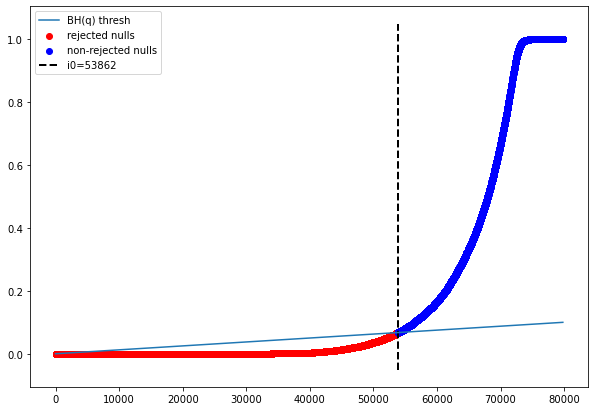

In [22]:
mht_bh(q=0.1, pvals=df_pvals_aa['pval'], plot=True)

name='C-C', m=20767, %rejected=0.39
name='A-A', m=79800, %rejected=67.50
name='A-C', m=3445, %rejected=0.32


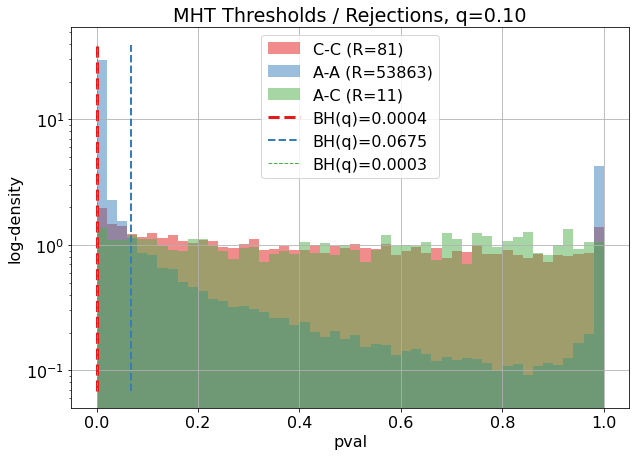

In [23]:
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(1, 1, figsize=(10, 7));
colors = plt.cm.Set1.colors

nbins = 50
q = 0.1

zip_name_df = tuple(zip(
    ["C-C", "A-A", "A-C"],
    [df_pvals_cc, df_pvals_aa, df_pvals_ac]
))

for i, (name, df) in enumerate(zip_name_df):
    thresh = mht_bh(q, df['pval'])
    num_rejections = np.sum(df['pval'] < thresh)
    df.hist(
        'pval',
        bins=nbins,
        ax=ax,
        density=True,
        log=True,
        color=colors[i],
        alpha=0.5,
        label=f"{name} (R={num_rejections})",
    )
    m = len(df['pval'])
    print(f"{name=}, {m=}, %rejected={num_rejections/m*100:.2f}")
    
    
ymin, ymax = ax.get_ylim()
for i, (name, df) in enumerate(zip_name_df):
    thresh = mht_bh(q, df['pval'])
    ax.vlines(
        thresh,
        ymin, ymax,
        linewidths=1*(len(zip_name_df)-i),
        linestyles="dashed",
        colors=colors[i],
        label=f"BH(q)={thresh:.04f}"
    )

ax.set_title(f"MHT Thresholds / Rejections, {q=:.2f}")
ax.set_ylabel("log-density")
ax.set_xlabel("pval")
ax.legend();
fig.savefig("out/pointwise_pvals_hist.png", bbox_inches="tight", dpi=150)